# Deep Q-Network (DQN)

Deep Q-Network (DQN) is a neural network (deep learning) method, which idea is strongly motivated by plain Q-learning discussed in [previous example](./00-q-learning.ipynb).

As we saw in the [previous tutorial](./00-q-learning.ipynb), discretizing states in Q-table is not computationally efficient and not smart.<br>
To address this concern, in deep Q-learning algorithm, we apply Q-function instead of Q-table to get optimal action for the current state, and implement this function by building neural networks (deep learning), called Q-network. (See below.)

![Q-Network](./assets/q-network.png)

Same as [previous tutorial](./00-q-learning.ipynb), we then optimize Q-network (instead of Q-table) to meet the actual experiments, but there exist several tricks to improve training stability in Deep Q-Network (DQN) algorithm.

Now let's see what these tricks are and how these are implemented.

*(back to [index](https://github.com/tsmatz/reinforcement-learning-tutorials/))*

First, please install the required packages and import these modules.

In [ ]:
!pip install torch==1.13.1 --extra-index-url https://download.pytorch.org/whl/cpu

In [ ]:
!pip install gym matplotlib numpy

In [1]:
import random
import numpy as np
import gym
import torch
import torch.nn as nn
from torch.nn import functional as F

Firstly, we will start with the following equation (Bellman equation) discussed in [Q-learning](./00-q-learning.ipynb) :

$$ Q^{*}(s_t,a_t) = r_t + \gamma \max_a{Q(s_{t+1},a)}$$

where $ Q^{*} $ means the optimal $ Q $ value.

Same as [previous example](./00-q-learning.ipynb), here we optimize this Q-function $ Q(\cdot) $ to minimize the difference between $ r_t + \gamma \max_a{Q(s_{t+1},a)} $ and $ Q(s_t,a_t) $ with epsilon-greedy sampling. (See [previous example](./00-q-learning.ipynb) for epsilon-greedy sampling.)

However, in DQN, we separate a network for generating the target $ \max_a{Q(s_{t+1},a)} $ from the original Q-network $ Q(s_t,a_t) $. (See below picture.)<br>
Remember that we also have updated the value of only current state $ s_t $ (not the next state $ s_{t+1} $) in previous example. If the target network is same as Q-network, the weights of target is also changed in optimization, and it will eventually lose the stability of training. The algorithm then separates a target network to keep the weights of target network not updated (not trained) in optimization. (See below note.)

> Note : Especially, when it has an explicit goal state, firstly the states near the goal state are then optimized, and other states will gradually be optimized in order from the goal to start. Finally the trajectory to reach the goal will be found by optimization.<br>
> When it has an explicit fail state, it's also the same. (The trajectory not to fail will be found by optimization.)<br>
> In this situation, the value of $ s_{t+1} $ will be optimized before the optimization of the value of $ s_t $. (The optimization of $ s_t $ strongly depends on the optimization of $ s_{t+1} $.)

Every $ C $ updates, it then clone Q-network to obtain a new target network. i.e, The update of target Q-Network is deplayed.<br>
(In this example, we'll set $ C=50 $.)

![2 networks in DQN](./assets/dqn-2-networks.png)

Thus we build 2 networks - Q-network and target Q-network - as follows.<br>
This network (PyTorch module) outputs 2 values, in which each value corresponds to the expected Q-value in each action. (See [previous example](./00-q-learning.ipynb) for Q-value.)<br>
In this CartPole example, we have 2 actions (left or right) and it then outputs 2 corresponding values.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class QNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        outs = self.output(outs)
        return outs

q_model = QNet().to(device)
q_target_model = QNet().to(device)
q_target_model.load_state_dict(q_model.state_dict())
_ = q_target_model.requires_grad_(False)  # target q-network doen't need grad

In primitive [Q-learning example](./00-q-learning.ipynb), we fed the sequential samples (trajectory) for each training (for optimizing Q-table).<br>
In DQN, to prevent from learning only for recent experiences and improve training stability, we use a replay memory (also called experience replay). The algorithm stores the last $ N $ experience tuples in this replay memory, and samples uniformly at random when performing updates. (See [paper](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf).)

In [3]:
class replayMemory:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
        self.buffer = []

    def add(self, item):
        if len(self.buffer) == self.buffer_size:
            self.buffer.pop(0)
        self.buffer.append(item)

    def sample(self, sample_size):
        # sampling
        items = random.sample(self.buffer, sample_size)
        # divide each columns
        states   = [i[0] for i in items]
        actions  = [i[1] for i in items]
        rewards  = [i[2] for i in items]
        n_states = [i[3] for i in items]
        dones    = [i[4] for i in items]
        # convert to tensor
        states = torch.tensor(states, dtype=torch.float).to(device)
        actions = torch.tensor(actions, dtype=torch.int64).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float).to(device)
        n_states = torch.tensor(n_states, dtype=torch.float).to(device)
        dones = torch.tensor(dones, dtype=torch.float).to(device)
        # return result
        return states, actions, rewards, n_states, dones

    def length(self):
        return len(self.buffer)

memory = replayMemory(buffer_size=10000)

In DQN, we'll minimize MSE (mean square error) to optimize as follows.<br>
In neural network, this value is called a loss and the network is then updated (optimized) to minimize a loss. :

$$ L = E \left[ \left( \left( r_t + \gamma \max_a{Q(s_{t+1},a)} \right) - Q(s_t,a) \right)^2 \right] $$

> Note : I have denoted as $ E[\cdot] $ (i.e, expected value), because the neural network is optimized to minimize loss for all possible samples in batch, not only for a single loss.<br>
> This (expected value) is also stylized as $ \mathbb{E} [\cdot] $.

However, when it's terminal state in episode, the next state doesn't exist and a loss becomes $ ( r_t - Q(s_t,a) )^2 $.<br>
So the final loss expression will become :

$$ L = E \left[ \left( \left( r_t + \gamma (1 - d_t) \max_a{Q(s_{t+1},a)} \right) - Q(s_t,a) \right)^2 \right] $$

where $d_t = 1$ if the episode is done, and $0$ otherwise.

> Note : CartPole returns "done" flag as termination (term) or truncation (trunc) separately.<br>
> When it fails and is terminated, it returns True in termination flag. When it reaches to max 500 actions, it returns True in truncation flag. (See [Readme.md](./Readme.md).)<br>
> For this reason, we will set $d_t=1$ only when termination is True. (If we set $d_t=1$ in truncation, the q-value in this state will then be underestimated, even though it's successful.)

In [4]:
gamma = 0.99

opt = torch.optim.Adam(q_model.parameters(), lr=0.0005)

def optimize(states, actions, rewards, next_states, dones):
    #
    # Compute target
    #

    with torch.no_grad():
        # compute Q(s_{t+1})                               : size=[batch_size, 2]
        target_vals_for_all_actions = q_target_model(next_states)
        # compute argmax_a Q(s_{t+1})                      : size=[batch_size]
        target_actions = torch.argmax(target_vals_for_all_actions, 1)
        # compute max Q(s_{t+1})                           : size=[batch_size]
        target_actions_one_hot = F.one_hot(target_actions, env.action_space.n).float()
        target_vals = torch.sum(target_vals_for_all_actions * target_actions_one_hot, 1)
        # compute r_t + gamma * (1 - d_t) * max Q(s_{t+1}) : size=[batch_size]
        target_vals_masked = (1.0 - dones) * target_vals
        q_vals1 = rewards + gamma * target_vals_masked

    opt.zero_grad()

    #
    # Compute q-value
    #
    actions_one_hot = F.one_hot(actions, env.action_space.n).float()
    q_vals2 = torch.sum(q_model(states) * actions_one_hot, 1)

    #
    # Get MSE loss and optimize
    #
    loss = F.mse_loss(
        q_vals1.detach(),
        q_vals2,
        reduction="mean")
    loss.backward()
    opt.step()

Now let's put it all together and start training (optimizing Q-network).

As you saw in [previous example](./00-q-learning.ipynb), we also apply epsilon-greedy strategy for sampling actions.<br>
When it always picks up random actions, the agent won't converge into the optimal behaviors. On contrary, when it always picks up the optimal action, it never explore the new actions and it won't then also converge into the optimal behaviors.<br>
With epsilon-greedy strategy, it explores new actions in early stage, but gradually picks up the optimal actions to train. (This strategy adjusts the trade-off between exploration and exploitation.)

In [5]:
sampling_size = 64 * 30
batch_size = 64

epsilon = 1.0
epsilon_decay = epsilon / 3000
epsilon_final = 0.1

env = gym.make("CartPole-v1")

# pick up action from q-network with greedy exploration
def pick_sample(s, epsilon):
    with torch.no_grad():
        # get optimal action,
        # but with greedy exploration (to prevent picking up same values in the first stage)
        if np.random.random() > epsilon:
            s_batch = torch.tensor(s, dtype=torch.float).to(device)
            s_batch = s_batch.unsqueeze(dim=0)  # to make batch with size=1
            q_vals_for_all_actions = q_model(s_batch)
            a = torch.argmax(q_vals_for_all_actions, 1)
            a = a.squeeze(dim=0)
            a = a.tolist()
        else:
            a = np.random.randint(0, env.action_space.n)
        return a

# evaluate current agent with no exploration
def evaluate():
    with torch.no_grad():
        s, _ = env.reset()
        done = False
        total = 0
        while not done:
            a = pick_sample(s, 0.0)
            s_next, r, term, trunc, _ = env.step(a)
            done = term or trunc
            total += r
            s = s_next
        return total

reward_records = []
for _ in range(15000):
    # Run episode till it picks up 500 samples
    # (All samples are stored in reply memory.)
    done = True
    for _ in range(500):
        if done:
            s, _ = env.reset()
            done = False
            cum_reward = 0

        a = pick_sample(s, epsilon)
        s_next, r, term, trunc, _ = env.step(a)
        done = term or trunc
        memory.add([s.tolist(), a, r, s_next.tolist(), float(term)])  # (see above note for truncation)
        cum_reward += r
        s = s_next

    # Init replay memory (without updates) till 2000 samples are filled
    if memory.length() < 2000:
        continue

    # Optimize Q-network with a batch from replay memory
    states, actions, rewards, n_states, dones = memory.sample(sampling_size)
    states = torch.reshape(states, (-1, batch_size, 4))
    actions = torch.reshape(actions, (-1, batch_size))
    rewards = torch.reshape(rewards, (-1, batch_size))
    n_states = torch.reshape(n_states, (-1, batch_size, 4))
    dones = torch.reshape(dones, (-1, batch_size))
    for j in range(actions.size(dim=0)):
        optimize(states[j], actions[j], rewards[j], n_states[j], dones[j])
    total_reward = evaluate()
    reward_records.append(total_reward)
    iteration_num = len(reward_records)
    print("Run iteration {} rewards {:3} epsilon {:1.5f}".format(iteration_num, total_reward, epsilon), end="\r")

    # Clone Q-network to obtain target
    if iteration_num % 50 == 0:
        q_target_model.load_state_dict(q_model.state_dict())

    # Update epsilon
    if epsilon - epsilon_decay >= epsilon_final:
        epsilon -= epsilon_decay

    # stop if reward mean > 495.0
    if np.average(reward_records[-200:]) > 495.0:
       break

env.close()
print("\nDone")

/home/tsmatsuz/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Run iteration 9754 rewards 500.0 epsilon 0.10000
Done


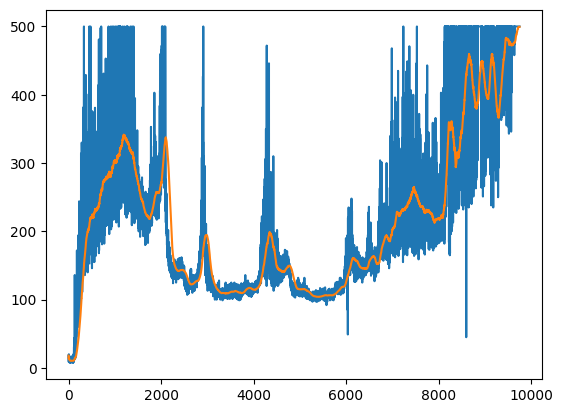

In [6]:
import matplotlib.pyplot as plt
# Generate recent 150 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 150:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-149:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)

In this example, I have briefly showed you a neural network architecture, DQN, which is motivated by Q-learning.

Today, in order to prevent overestimation, there exist variants of deep Q-learning - such as, **Double DQN** (which decouples Q-network for selecting actions from Q-network for evaluating actions) or **Dueling DQN** (in which dueling architecture explicitly separates value and advantage. see [Actor-Critic method](./03-actor-critic.ipynb) for value and advantage).<br>
See [TD3](./05-ddpg.ipynb) or [SAC](./06-sac.ipynb) for more advanced off-policy algorithms and the implementation to apply double Q-learning.